# Step 4 - Analysis of bicycle network results
## Project: Growing Urban Bicycle Networks with LTNs

This notebook takes the existing infrastructure, the results from 03_poi_based_generation and calculates/analyzes a number of measures:
* cost (length)
* coverage  
* directness  
* efficiency
* overlap with existing networks

Contact: Chris Larkin (c.larkin@ncl.ac.uk)  
Created: 2020-07-08  
Last modified: 2024-09-24

## Preliminaries

### Parameters

In [1]:
debug = True # If True, will produce plots and/or verbose output to double-check
rerun_existing = True # If True, will re-run the costly analysis of existing infra even if files already exist.
%run -i "../parameters/parameters.py"

Loaded parameters.



### Setup

In [2]:
%run -i path.py
%run -i setup.py
if not debug: # Only do this if sure the code is bug-free!
    warnings.filterwarnings('ignore')

%load_ext watermark
#%watermark -n -v -m -g -iv

Loaded PATH.



=== Cities ===
{   'newcastle': {   'countryid': 'gbr',
                     'name': 'Newcastle upon Tyne',
                     'nominatimstring': 'Newcastle upon Tyne'}}


Setup finished.



### Functions

In [3]:
%run -i functions.py

Loaded functions.



### Network weighting by tags

In [4]:
%run -i tag_lts.py
%run -i distance_cost.py

## Loading

### Load Results

In [5]:
# betweeness
filename = PATH["results"] + placeid + "/" + f"{placeid}_poi_{poi_source}_{prune_measure}_weighted.pickle"  

if os.path.exists(filename):
    with open(filename, "rb") as f:
        results = pickle.load(f)
else:
    print(f"File {filename} does not exist.")

In [6]:
# random
filename = PATH["results"] + placeid + "/" + f"{placeid}_poi_{poi_source}_random_weighted.pickle"  

if os.path.exists(filename):
    with open(filename, "rb") as f:
        results_random = pickle.load(f)
else:
    print(f"File {filename} does not exist.")

In [7]:
# # how to access....
# investment_levels = results["prune_quantiles"]
# GTs = results["GTs"]
# GT_abstracts = results["GT_abstracts"]

# # For example, convert the first graph in GTs to GeoDataFrames
# import osmnx as ox
# nodes, edges = ox.graph_to_gdfs(GTs[0])


Find investment level, split results into GTs, GT_abstracts 

In [8]:
investment_levels = results["prune_quantiles"]
investment_levels_random = results_random["prune_quantiles"]
GTs = results["GTs"]
GT_abstracts = results["GT_abstracts"]

if results_random:
    GTs_random = results_random["GTs"]
    GT_abstracts_random = results_random["GT_abstracts"]

### Load existing networks, nodes, GeoDataframe



In [ ]:
for placeid, placeinfo in tqdm(cities.items(), desc="Networks for Cities"):
    # get biketrack graph
    gpkg_path = PATH["data"] + placeid + "/" + placeid + '_biketrack.gpkg'
    G_biketrack = ox_gpkg_to_graph(gpkg_path)
    G_biketrack.remove_nodes_from(list(nx.isolates(G_biketrack)))


    # get biketrack graph without LTNs
    gpkg_path = PATH["data"] + placeid + "/" + placeid + '_biketrack_no_ltn.gpkg'
    G_biketrack_no_ltn = ox_gpkg_to_graph(gpkg_path)
    G_biketrack_no_ltn.remove_nodes_from(list(nx.isolates(G_biketrack)))


    # get biketrack graph without LTNs
    gpkg_path = PATH["data"] + placeid + "/" + placeid + '_biketrackcarall.gpkg'
    G_biketrackcarall = ox_gpkg_to_graph(gpkg_path)
    G_biketrackcarall.remove_nodes_from(list(nx.isolates(G_biketrackcarall)))
    
    G_biketrackcarall_edges = ox.graph_to_gdfs(G_biketrackcarall, nodes=False)


Networks for Cities:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
# get nodes 

for placeid, placeinfo in tqdm(cities.items(), desc="Points for Cities"):
    tess_points = gpd.read_file(PATH["data"] + placeid + "/" + placeid + '_tess_points.gpkg')
    ltn_points = gpd.read_file(PATH["data"] + placeid + "/" + placeid + '_ltn_points.gpkg')
    combined_points = gpd.read_file(PATH["data"] + placeid + "/" + placeid + '_combined_points.gpkg')


Points for Cities:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# get ltns and all neighbourhoods
ltns = load_neighbourhoods(PATH["data"] + placeid + "/")
key, df = next(iter(ltns.items()))  # Get the first key and its GeoDataFrame  
ltns = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")  
#ltns.explore()

# all neighbourhoods (regardless of their "low traffic" status)
all_neighbourhoods = gpd.read_file(PATH["data"] + placeid + "/" + 'neighbourhoods_'+  placeid + '.gpkg') # currently need to manually drag and drop in
all_neighbourhoods_centroids = all_neighbourhoods.geometry.centroid
all_neighbourhoods_centroids = gpd.GeoDataFrame(geometry= all_neighbourhoods_centroids, crs=all_neighbourhoods.crs)

1 Cities loaded


In [12]:
# setup

def csv_to_ox(p, placeid, parameterid):
    '''
    Load graph from csv files (nodes and edge)
    Include OSMID, length, highway, x, y attributes
    '''

    prefix = placeid + '_' + parameterid
    compress = check_extract_zip(p, prefix)
    
    with open(p + prefix + '_edges.csv', 'r') as f:
        header = f.readline().strip().split(",")
        lines = []
        for line in csv.reader(f, quotechar='"', delimiter=',', quoting=csv.QUOTE_ALL, skipinitialspace=True):
            line_list = [c for c in line]
            osmid = str(eval(line_list[header.index("osmid")])[0]) if isinstance(eval(line_list[header.index("osmid")]), list) else line_list[header.index("osmid")]
            length = str(eval(line_list[header.index("length")])[0]) if isinstance(eval(line_list[header.index("length")]), list) else line_list[header.index("length")]
            highway = line_list[header.index("highway")]
            if highway.startswith("[") and highway.endswith("]"):
                highway = highway.strip("[]").split(",")[0].strip(" '")
            line_string = f"{line_list[header.index('u')]} {line_list[header.index('v')]} {osmid} {length} {highway}"
            lines.append(line_string)
        G = nx.parse_edgelist(lines, nodetype=int, data=(("osmid", int), ("length", float), ("highway", str)), create_using=nx.MultiDiGraph)
    
    with open(p + prefix + '_nodes.csv', 'r') as f:
        header = f.readline().strip().split(",")
        values_x = {}
        values_y = {}
        for line in csv.reader(f, quotechar='"', delimiter=',', quoting=csv.QUOTE_ALL, skipinitialspace=True):
            line_list = [c for c in line]
            osmid = int(line_list[header.index("osmid")])
            values_x[osmid] = float(line_list[header.index("x")])
            values_y[osmid] = float(line_list[header.index("y")])
        nx.set_node_attributes(G, values_x, "x")
        nx.set_node_attributes(G, values_y, "y")
    
    if compress:
        os.remove(p + prefix + '_nodes.csv')
        os.remove(p + prefix + '_edges.csv')
    return G



# Analyse

### Prelimiary Length

Length - finding the distance of the connected network, along with the investment distance (length - existing infrastructure)

In [ ]:
# # Get the first 5 edges
# edges = list(G.edges(data=True))[:5]

# # Print the edge attributes
# for edge in edges:
#     print(edge)

In [ ]:
# Extract lengths of all edges in G_biketrack
lengths_biketrack = nx.get_edge_attributes(G_biketrack, 'length')
total_length_biketrack = sum(lengths_biketrack.values())

# Extract lengths of all edges in G_biketrack_no_ltn
lengths_biketrack_no_ltn = nx.get_edge_attributes(G_biketrack_no_ltn, 'length')
total_length_biketrack_no_ltn = sum(lengths_biketrack_no_ltn.values())

# Calculate the difference
difference_in_length = total_length_biketrack - total_length_biketrack_no_ltn


for G in GTs:
    for u, v, data in G.edges(data=True):
        highway_type = data.get('highway', 'unclassified') # Default to unclassified if no highway attribute
        length = data.get('length', 0) # Default to 0 if no length attribute
        investment_length = length * distance_cost.get(highway_type, 1) 
        data['investment_length'] = investment_length # make a new edge attribute called investment_length
    
investment_lengths = nx.get_edge_attributes(G, 'investment_length')

total_investment_length = sum(investment_lengths.values())






complete_network = GTs[-1]
final_lengths = nx.get_edge_attributes(complete_network , 'length')
total_final_length = sum(final_lengths.values())

print(f"Total length of fully connected network: {total_final_length}")
print(f"Total length of G_biketrack: {total_length_biketrack}")
print(f"Total length of G_biketrack_no_ltn: {total_length_biketrack_no_ltn}")
print(f"Difference in total length: {difference_in_length}")

In [ ]:
# Calculate the absolute difference
ltn_difference = abs(total_length_biketrack - total_length_biketrack_no_ltn)

# Data for plotting
labels = [
    "Existing Cycle Infrastructure (Including LTNs)",
    "Existing Cycle Infrastructure (Excluding LTNs)",
    "LTNs", 
    "Fully Connected Cycle Network",
    "Investment Distance"
]
values = [total_length_biketrack, total_length_biketrack_no_ltn, ltn_difference, total_final_length, total_investment_length]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['deepskyblue', 'deepskyblue', 'deepskyblue'])
plt.xlabel('Network Type')
plt.ylabel('Total Length (meters)')
plt.title('Lengths of Cycle Networks')


plt.tight_layout()
plt.show()

#### Pure length - how is the budget used per iteration

In [ ]:
total_lengths = []
for G in GTs:
    # Use nx.get_edge_attributes to retrieve the edge lengths
    lengths = nx.get_edge_attributes(G, 'length')  # Returns a dictionary {edge: length}
    total_length = sum(lengths.values())  # Sum up the lengths
    total_lengths.append(total_length)

# Plot the total lengths
plt.figure(figsize=(5, 5))  # Narrower and taller dimensions
plt.plot(total_lengths, linestyle='-', color='orange')
plt.xlabel('Investment Iteration')
plt.ylabel('Total Length (meters)')
plt.title('Length of Invested Cycle Network - Betweeness')
plt.grid(True)
plt.tight_layout()  # Adjust spacing for a clean look
plt.show()

In [ ]:
total_lengths = []
for G in GTs_random:
    # Use nx.get_edge_attributes to retrieve the edge lengths
    lengths = nx.get_edge_attributes(G, 'length')  # Returns a dictionary {edge: length}
    total_length = sum(lengths.values())  # Sum up the lengths
    total_lengths.append(total_length)

# Plot the total lengths
plt.figure(figsize=(5, 5))  # Narrower and taller dimensions
plt.plot(total_lengths, linestyle='-', color='orange')
plt.xlabel('Investment Iteration')
plt.ylabel('Total Length (meters)')
plt.title('Length of Invested Cycle Network - Random')
plt.grid(True)
plt.tight_layout()  # Adjust spacing for a clean look
plt.show()

In [ ]:

total_lengths = []
for G in GTs:
    lengths = nx.get_edge_attributes(G, 'length')
    total_length = sum(lengths.values())
    total_lengths.append(total_length)

plt.figure(figsize=(5, 5))
plt.plot(total_lengths, linestyle='-', color='orange', label='Betweeness Growth')

# Plot the total lengths for Random_GTs
random_total_lengths = []
for G in GTs_random:
    lengths = nx.get_edge_attributes(G, 'length')
    total_length = sum(lengths.values())
    random_total_lengths.append(total_length)

plt.plot(random_total_lengths, linestyle='--', color='blue', label='Random Growth')

plt.xlabel('Investment Iteration')
plt.ylabel('Total Length (meters)')
plt.title('Length of Invested Cycle Network')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### "Actual" investment length - how much do we actually need to use to close gaps

Calculate length, minus the existing infrastructure

In [ ]:
for G in GTs:
    for u, v, data in G.edges(data=True):
        highway_type = data.get('highway', 'unclassified') # Default to unclassified if no highway attribute
        length = data.get('length', 0) # Default to 0 if no length attribute
        investment_length = length * distance_cost.get(highway_type, 1) 
        data['investment_length'] = investment_length # make a new edge attribute called investment_length

if GTs_random:
    for G in GTs_random:
        for u, v, data in G.edges(data=True):
            highway_type = data.get('highway', 'unclassified')
            length = data.get('length', 0)
            investment_length = length * distance_cost.get(highway_type, 1)
            data['investment_length'] = investment_length



#### Find how much we actually need to invest

In [ ]:

total_lengths = []
for G in GTs:
    lengths = nx.get_edge_attributes(G, 'investment_length')
    total_length = sum(lengths.values())
    total_lengths.append(total_length)

plt.figure(figsize=(5, 5))
plt.plot(total_lengths, linestyle='-', color='orange', label='Betweeness Growth')

# Plot the total lengths for Random_GTs
random_total_lengths = []
for G in GTs_random:
    lengths = nx.get_edge_attributes(G, 'investment_length')
    total_length = sum(lengths.values())
    random_total_lengths.append(total_length)

plt.plot(random_total_lengths, linestyle='--', color='blue', label='Random Growth')

plt.xlabel('Investment Iteration')
plt.ylabel('Total Length (meters)')
plt.title('Length of Investment needed')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Find comparison between how much we need against full route lengths

In [ ]:
# Compute total lengths using 'investment_length'
investment_total_lengths = [sum(nx.get_edge_attributes(G, 'investment_length').values()) for G in GTs]
random_investment_total_lengths = [sum(nx.get_edge_attributes(G, 'investment_length').values()) for G in GTs_random]

# Compute total lengths using 'length'
length_total_lengths = [sum(nx.get_edge_attributes(G, 'length').values()) for G in GTs]
random_length_total_lengths = [sum(nx.get_edge_attributes(G, 'length').values()) for G in GTs_random]

# Plot both sets of lines
plt.figure(figsize=(6, 6))

# Original lines
plt.plot(investment_total_lengths, linestyle='-', color='orange', label='Betweenness Growth (Investment Length)')
plt.plot(random_investment_total_lengths, linestyle='--', color='blue', label='Random Growth (Investment Length)')

# Darker lines for 'length' attribute
plt.plot(length_total_lengths, linestyle='-', color='darkorange', alpha=0.7, label='Betweenness Growth (Total Length)')
plt.plot(random_length_total_lengths, linestyle='--', color='darkblue', alpha=0.7, label='Random Growth (Total Length)')

plt.xlabel('Investment Iteration')
plt.ylabel('Total Length (meters)')
plt.title('Network size vs investment required comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Find differance between network size and required investment

In [ ]:
length_differences = []
for G in GTs:
    lengths = nx.get_edge_attributes(G, 'length')
    investment_lengths = nx.get_edge_attributes(G, 'investment_length')
    total_length = sum(lengths.values())
    total_investment_length = sum(investment_lengths.values())
    length_difference = total_length - total_investment_length
    length_differences.append(length_difference)

random_length_differences = []
for G in GTs_random:
    random_lengths = nx.get_edge_attributes(G, 'length')
    random_investment_lengths = nx.get_edge_attributes(G, 'investment_length')
    random_total_length = sum(random_lengths.values())
    random_total_investment_length = sum(random_investment_lengths.values())
    random_length_difference = random_total_length - random_total_investment_length
    random_length_differences.append(random_length_difference)




# Plot the length differences
plt.figure(figsize=(5, 5))
plt.plot(length_differences, linestyle='-', color='green', label='Betweenness Growth')
plt.plot(random_length_differences, linestyle='--', color='blue', label='Random Growth')
plt.xlabel('Investment Iteration')
plt.ylabel('Length Difference (meters)')
plt.title('Length Difference between total network size and investment size required')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
lengths_list = []
investment_lengths_list = []

random_lengths_list = []
random_investment_lengths_list = []

# Process GTs
for G in GTs:
    lengths = nx.get_edge_attributes(G, 'length')
    investment_lengths = nx.get_edge_attributes(G, 'investment_length')
    
    total_length = sum(lengths.values())
    total_investment_length = sum(investment_lengths.values())
    
    lengths_list.append(total_length)
    investment_lengths_list.append(total_investment_length)

# Process GTs_random
for G in GTs_random:
    lengths = nx.get_edge_attributes(G, 'length')
    investment_lengths = nx.get_edge_attributes(G, 'investment_length')
    
    total_length = sum(lengths.values())
    total_investment_length = sum(investment_lengths.values())
    
    random_lengths_list.append(total_length)
    random_investment_lengths_list.append(total_investment_length)

# Plot the lengths against investment lengths
plt.figure(figsize=(8, 6))
plt.plot(lengths_list, investment_lengths_list, '-', color='purple', label='Betweenness Growth')
plt.plot(random_lengths_list, random_investment_lengths_list, '--', color='blue', label='Random Growth')
plt.xlabel('Total Length (meters)')
plt.ylabel('Total Investment Length (meters)')
plt.title('Investment Length vs. Length for GTs and GTs_random')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Distance gained

Here we are trying to find how much of the existing network is connected per iteration. 

total bike network - G_bikeall

G'investment_length' - investment size

G'length' - length of created network, not including netowrk size

need to do a compose of G_bikeall and G in GTs

but only compose where infrastucutre is connected to our generated network 

Find the length of infrastructure connected to generated network, along with the combined length. Thus we now know how much extra cycle network is connected per level of investment.

In [ ]:
def total_length(G):
    """Computes total edge length in a graph."""
    return sum(data.get('length', 1) for _, _, data in G.edges(data=True))

def compute_lengths(graph_list, G_biketrack):
    """Computes total, connected, and combined lengths for a list of graphs."""
    G_lengths = []
    biketrack_lengths = []
    combined_lengths = []

    for G in graph_list:
        length_G = total_length(G)

        # Find overlapping nodes
        common_nodes = set(G.nodes) & set(G_biketrack.nodes)

        # Extract the connected subgraph of G_biketrack
        G_biketrack_subgraph = G_biketrack.subgraph(common_nodes)
        length_G_biketrack_connected = total_length(G_biketrack_subgraph)

        # Compute final combined length
        total_combined_length = length_G + length_G_biketrack_connected

        # Store values for plotting
        G_lengths.append(length_G)
        biketrack_lengths.append(length_G_biketrack_connected)
        combined_lengths.append(total_combined_length)

    return G_lengths, biketrack_lengths, combined_lengths

# Compute lengths for both GTs and GTs_random
G_lengths, biketrack_lengths, combined_lengths = compute_lengths(GTs, G_biketrack)
G_random_lengths, biketrack_random_lengths, combined_random_lengths = compute_lengths(GTs_random, G_biketrack)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot GTs
#plt.plot(range(1, len(GTs) + 1), G_lengths, marker='o', linestyle='-', color='blue', label="G (GTs)")
plt.plot(range(1, len(GTs) + 1), biketrack_lengths,  linestyle='-', color='green', label="Betweeness")
#plt.plot(range(1, len(GTs) + 1), combined_lengths, marker='^', linestyle='-', color='purple', label="Combined Total (GTs)")

# Plot GTs_random
#plt.plot(range(1, len(GTs_random) + 1), G_random_lengths, marker='o', linestyle='--', color='red', label="G (GTs_random)")
plt.plot(range(1, len(GTs_random) + 1), biketrack_random_lengths,  linestyle='--', color='orange', label="Random)")
#plt.plot(range(1, len(GTs_random) + 1), combined_random_lengths, marker='^', linestyle='--', color='brown', label="Combined Total (GTs_random)")

# Labels and title
plt.xlabel("Iteration")
plt.ylabel("Addtional Cycle Infrastucture Connected Length (meters)")
plt.title("Graph Length Comparisons (GTs vs. GTs_random)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


### Connected Components 

Find the length of the largest connected component, first a just our investment, then combined with existing network, then by combined but only where its connected

In [ ]:
# just grown networks

# Compute the largest connected component lengths for each graph in GTs
lcc_lengths_GTs = []
for G in GTs:
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    subgraph = G.subgraph(largest_cc)
    length_lcc = sum(data['length'] for u, v, data in subgraph.edges(data=True))
    lcc_lengths_GTs.append(length_lcc)

# Compute the largest connected component lengths for each graph in GTs_random
lcc_lengths_GTs_random = []
for G in GTs_random:
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    subgraph = G.subgraph(largest_cc)
    length_lcc = sum(data['length'] for u, v, data in subgraph.edges(data=True))
    lcc_lengths_GTs_random.append(length_lcc)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(lcc_lengths_GTs, linestyle='-', color='blue', label='GTs - Largest Connected Component')
plt.plot(lcc_lengths_GTs_random, linestyle='--', color='orange', label='GTs_random - Largest Connected Component')
plt.xlabel('Graph Index')
plt.ylabel('Length (meters)')
plt.title('Length of Largest Connected Component per Iteration')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
def compute_lcc_lengths(graph_list, G_biketrack):
    """Computes the total length of the largest connected component for each graph in the list."""
    total_lengths_lcc = []
    
    for G in graph_list:
        # Compose graphs and find largest connected component
        merged = nx.compose(G, G_biketrack)
        
        # Get weakly connected components (works for both directed/undirected graphs)
        components = list(nx.weakly_connected_components(merged))
        
        if not components:
            total_length = 0.0  # Handle empty graph case
        else:
            # Find largest component by node count
            largest_component_nodes = max(components, key=len)
            largest_component = merged.subgraph(largest_component_nodes)
            
            # Calculate total edge length in the largest component
            total_length = sum(data['length'] for u, v, data in largest_component.edges(data=True))
        
        total_lengths_lcc.append(total_length)
    
    return total_lengths_lcc

# Compute LCC lengths for GTs and GTs_random
total_lengths_lcc_GTs = compute_lcc_lengths(GTs, G_biketrack)
total_lengths_lcc_GTs_random = compute_lcc_lengths(GTs_random, G_biketrack)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot GTs
plt.plot(
    range(len(total_lengths_lcc_GTs)), total_lengths_lcc_GTs, linestyle='-', color='blue', label="GTs"
)

# Plot GTs_random
plt.plot(
    range(len(total_lengths_lcc_GTs_random)), total_lengths_lcc_GTs_random, linestyle='--', color='orange', label="GTs_random"
)

# Labels and title
plt.title('Total Length of Largest Connected Component')
plt.xlabel('Graph Index')
plt.ylabel('Total Length (meters)')
plt.grid(True, axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:


def total_length(G):
    """Computes total edge length in a graph."""
    return sum(data.get('length', 1) for _, _, data in G.edges(data=True))

def compute_lcc_lengths(graph_list, G_biketrack):
    """Computes the total length of the largest connected component for each graph in the list."""
    lcc_lengths = []

    for G in graph_list:
        # Find the common nodes between G and G_biketrack
        common_nodes = set(G.nodes) & set(G_biketrack.nodes)

        # If there are no common nodes, we can't compose, so we skip and set LCC length to 0
        if not common_nodes:
            lcc_lengths.append(0.0)
            continue
        
        # Create a subgraph of G_biketrack with only the common nodes
        G_biketrack_subgraph = G_biketrack.subgraph(common_nodes)

        # Merge G with the G_biketrack subgraph
        merged = nx.compose(G, G_biketrack_subgraph)

        # Find weakly connected components (works for both directed/undirected graphs)
        components = list(nx.weakly_connected_components(merged))

        if not components:
            total_length_lcc = 0.0  # Handle empty graph case
        else:
            # Find the largest connected component by node count
            largest_component_nodes = max(components, key=len)
            largest_component = merged.subgraph(largest_component_nodes)

            # Calculate total edge length in the largest component
            total_length_lcc = sum(data.get('length', 1) for u, v, data in largest_component.edges(data=True))

        lcc_lengths.append(total_length_lcc)

    return lcc_lengths

# Compute LCC lengths for both GTs and GTs_random
lcc_lengths_GTs = compute_lcc_lengths(GTs, G_biketrack)
lcc_lengths_GTs_random = compute_lcc_lengths(GTs_random, G_biketrack)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot LCC lengths for GTs
plt.plot(range(1, len(lcc_lengths_GTs) + 1), lcc_lengths_GTs, linestyle='-', color='blue', label="GTs - LCC Length")

# Plot LCC lengths for GTs_random
plt.plot(range(1, len(lcc_lengths_GTs_random) + 1), lcc_lengths_GTs_random, linestyle='--', color='orange', label="GTs_random - LCC Length")

# Labels and title
plt.xlabel("Graph Index")
plt.ylabel("Largest Connected Component Length (meters)")
plt.title("Largest Connected Component Length (GTs vs. GTs_random)")
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()


### Coverage

Prior to running any coverage analysis, we create buffers of each graph to avoid re-calculating

In [72]:
GTs_buffers = []

for G in GTs:
    gdf_edges = ox.graph_to_gdfs(G, nodes=False).to_crs(epsg=3857)
    buffer_gdf = gdf_edges.geometry.buffer(buffer_walk).unary_union
    buffer_gdf = gpd.GeoDataFrame(geometry=[buffer_gdf], crs=gdf_edges.crs)
    buffer_gdf = buffer_gdf.to_crs(epsg=4326)
    GTs_buffers.append(buffer_gdf)

GTs_buffers_random = []
for G in GTs_random:
    gdf_edges = ox.graph_to_gdfs(G, nodes=False).to_crs(epsg=3857)
    buffer_gdf = gdf_edges.geometry.buffer(buffer_walk).unary_union
    buffer_gdf = gpd.GeoDataFrame(geometry=[buffer_gdf], crs=gdf_edges.crs)
    buffer_gdf = buffer_gdf.to_crs(epsg=4326)
    GTs_buffers_random.append(buffer_gdf)

#### Area coverage

In [ ]:
target_crs = "EPSG:3857"
boundary_proj = boundary.to_crs(target_crs)
total_area = boundary_proj.unary_union.area  # total area in m²

# Function to compute areas (km²) and percentage coverage for a list of buffers
def compute_metrics(buffer_list):
    areas = []
    percentages = []
    for gdf in buffer_list:
        gdf_proj = gdf.to_crs(target_crs)
        inter = gpd.overlay(gdf_proj, boundary_proj, how='intersection')
        inter_area = inter.unary_union.area if not inter.empty else 0
        areas.append(inter_area / 1e6)  # convert m² to km²
        percentages.append((inter_area / total_area * 100) if total_area else 0)
    return areas, percentages

# Compute metrics for both buffer sets
areas1, perc1 = compute_metrics(GTs_buffers)
areas2, perc2 = compute_metrics(GTs_buffers_random)

# Plot 1: Compare areas (in km²) for both buffer sets on one graph
plt.figure(figsize=(10, 5))
plt.plot(areas1, 'b-o', label='GTs_buffers Area (km²)')
plt.plot(areas2, 'g-o', label='GTs_buffers_random Area (km²)')
plt.xlabel('Buffer Index')
plt.ylabel('Area (km²)')
plt.title('Boundary Intersection Area Comparison')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Compare coverage percentages for both buffer sets on one graph
plt.figure(figsize=(10, 5))
plt.plot(perc1, 'r-s', label='GTs_buffers Coverage (%)')
plt.plot(perc2, 'm-s', label='GTs_buffers_random Coverage (%)')
plt.xlabel('Buffer Index')
plt.ylabel('Coverage (%)')
plt.title('Boundary Coverage Percentage Comparison')
plt.legend()
plt.tight_layout()
plt.show()

#### Streets coverage

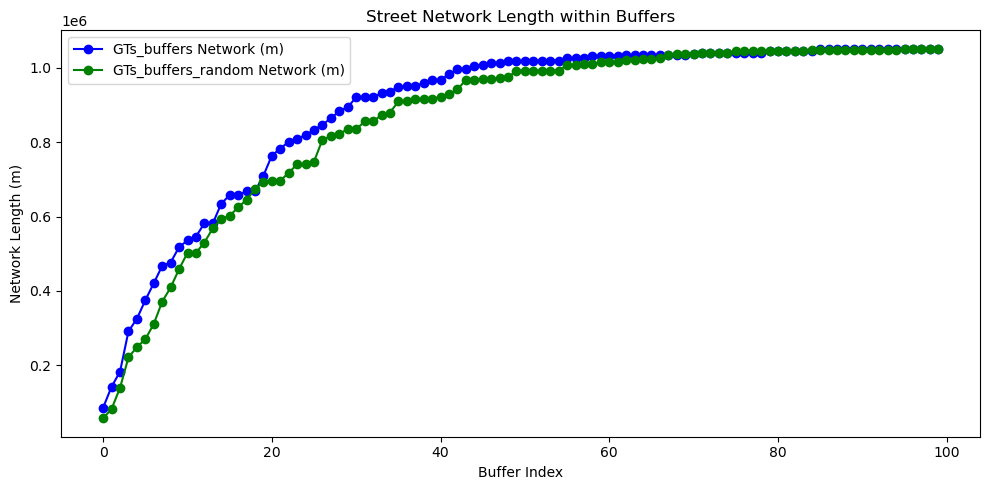

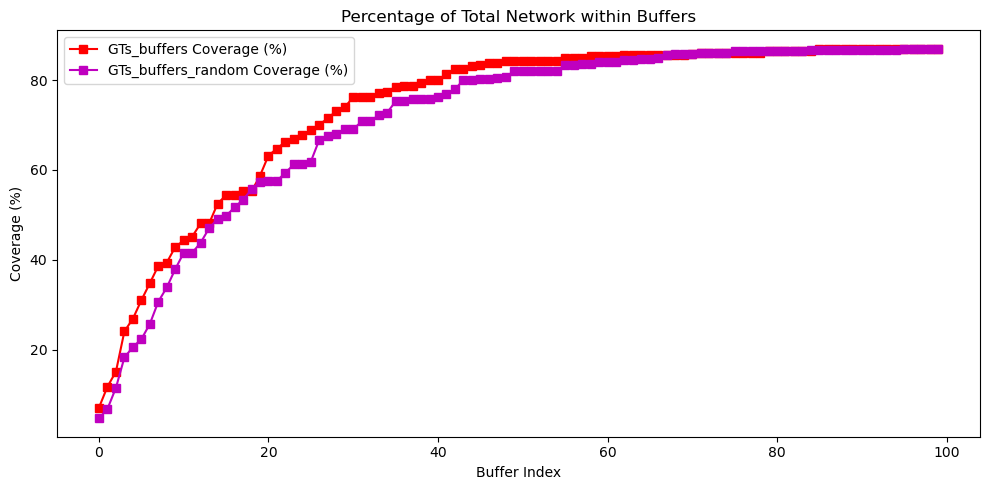

In [90]:
network_crs = G_biketrackcarall_edges.crs
total_network_length = G_biketrackcarall_edges["length"].sum()

def compute_street_coverage(buffer_list):
    lengths = []
    percentages = []
    for gdf in buffer_list:
        # Reproject buffers to network CRS if needed
        gdf_proj = gdf.to_crs(network_crs)
        # Compute intersection between network and buffer
        inter = gpd.overlay(G_biketrackcarall_edges, gdf_proj, how='intersection')
        # Sum the existing "length" values from the intersected segments
        seg_length = inter["length"].sum() if not inter.empty else 0
        lengths.append(seg_length)
        percentages.append((seg_length / total_network_length * 100) if total_network_length else 0)
    return lengths, percentages

# Compute metrics for both buffer sets
net_lengths1, net_perc1 = compute_street_coverage(GTs_buffers)
net_lengths2, net_perc2 = compute_street_coverage(GTs_buffers_random)

# Plot 1: Compare network lengths (in meters) within each buffer
plt.figure(figsize=(10, 5))
plt.plot(net_lengths1, 'b-o', label='GTs_buffers Network (m)')
plt.plot(net_lengths2, 'g-o', label='GTs_buffers_random Network (m)')
plt.xlabel('Buffer Index')
plt.ylabel('Network Length (m)')
plt.title('Street Network Length within Buffers')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Compare network coverage percentages
plt.figure(figsize=(10, 5))
plt.plot(net_perc1, 'r-s', label='GTs_buffers Coverage (%)')
plt.plot(net_perc2, 'm-s', label='GTs_buffers_random Coverage (%)')
plt.xlabel('Buffer Index')
plt.ylabel('Coverage (%)')
plt.title('Percentage of Total Network within Buffers')
plt.legend()
plt.tight_layout()
plt.show()

#### Population coverage

Get population data from census, asign census data to buildings, find population within cycle route buffer

In [91]:
# get lsoas and population
lsoa_bound = gpd.read_file(PATH["data"] + "/" + placeid + "/lsoa_bound.gpkg")
boundary = ox.geocode_to_gdf(placeinfo["nominatimstring"])
lsoa_bound = gpd.clip(lsoa_bound, boundary)
lsoa_bound = add_lsoa_population(lsoa_bound) # using 2011 census data

# get buildings
buildings = get_building_populations(lsoa_bound, boundary) ## add more detail??
buildings = buildings.to_crs(epsg=4326)

C:\Users\b8008458\AppData\Local\Temp\ipykernel_29888\764894356.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  buildings = buildings_joined.groupby('index_right', group_keys=False).apply(assign_pop)


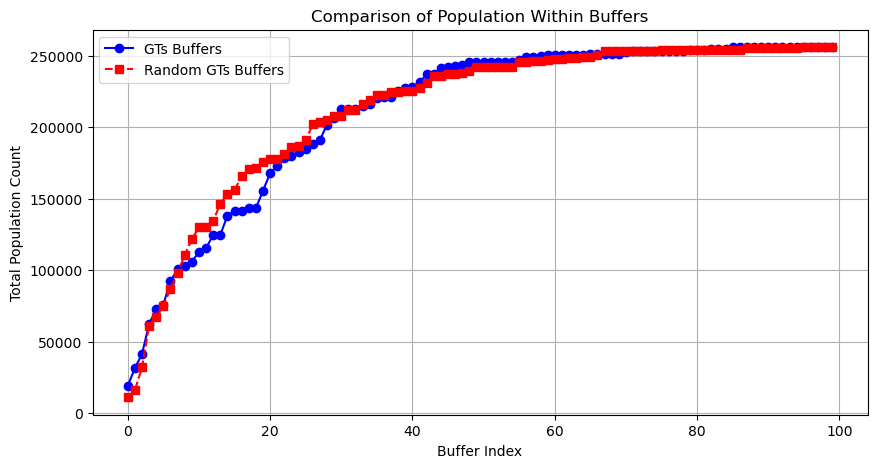

In [ ]:

pop_counts_GT = []
pop_counts_random_GT = []


# Function to calculate total pop_count within each buffer
def calculate_pop_count(buffers_list, buildings):
    pop_counts = []
    for buffer in buffers_list:
        intersecting_buildings = gpd.sjoin(buildings, buffer, predicate="intersects")
        total_pop = intersecting_buildings["pop_assigned"].sum()
        pop_counts.append(total_pop)
    return pop_counts

# Calculate for both sets of buffers
pop_counts_GT = calculate_pop_count(GTs_buffers, buildings)
pop_counts_random_GT = calculate_pop_count(GTs_buffers_random, buildings)

plt.figure(figsize=(10, 5))
buffer_indices = np.arange(len(GTs_buffers))  # Common x-axis indices for both datasets

plt.plot(buffer_indices, pop_counts_GT, label="GTs Buffers", linestyle='-', color='blue')
plt.plot(buffer_indices, pop_counts_random_GT, label="Random GTs Buffers", linestyle='--', color='orange')

plt.xlabel("Buffer Index")
plt.ylabel("Total Population Count")
plt.title("Comparison of Population Within Buffers")
plt.legend()
plt.grid(True)
plt.show()

#### POI coverage

##### Seed points

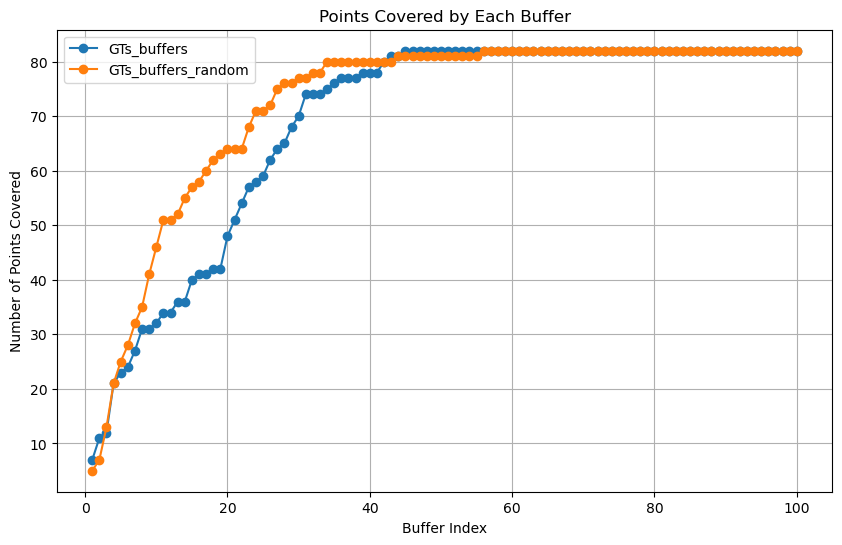

In [94]:
counts_buffers = []
counts_random = []

# Iterate over each buffer GeoDataFrame in GTs_buffers
for gdf in GTs_buffers:
    # Create a union of all polygons in the buffer gdf (if there is more than one)
    buffer_union = gdf.unary_union
    # Count the points in combined_points that fall within this union
    count = combined_points.within(buffer_union).sum()
    counts_buffers.append(count)

# Do the same for GTs_buffers_random
for gdf in GTs_buffers_random:
    buffer_union = gdf.unary_union
    count = combined_points.within(buffer_union).sum()
    counts_random.append(count)

# Plotting the results on a line graph
plt.figure(figsize=(10, 6))
x_vals = range(1, len(counts_buffers) + 1)  # Assuming you want x-axis as buffer index

plt.plot(x_vals, counts_buffers, marker='o', label='GTs_buffers')
plt.plot(x_vals, counts_random, marker='o', label='GTs_buffers_random')

plt.xlabel('Buffer Index')
plt.ylabel('Number of Points Covered')
plt.title('Points Covered by Each Buffer')
plt.legend()
plt.grid(True)
plt.show()

##### LTN Points

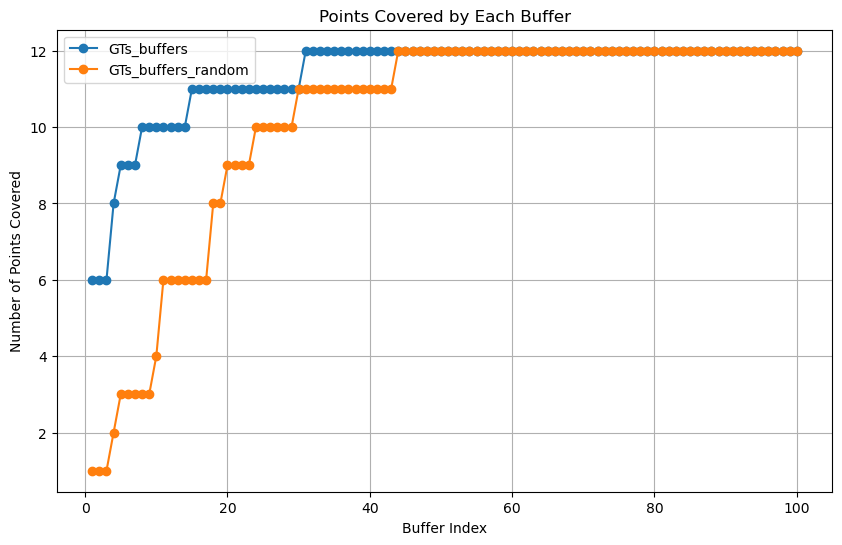

In [95]:
counts_buffers = []
counts_random = []

# Iterate over each buffer GeoDataFrame in GTs_buffers
for gdf in GTs_buffers:
    # Create a union of all polygons in the buffer gdf (if there is more than one)
    buffer_union = gdf.unary_union
    # Count the points that fall within this union
    count = ltn_points.within(buffer_union).sum()
    counts_buffers.append(count)

# Do the same for GTs_buffers_random
for gdf in GTs_buffers_random:
    buffer_union = gdf.unary_union
    count = ltn_points.within(buffer_union).sum()
    counts_random.append(count)

# Plotting the results on a line graph
plt.figure(figsize=(10, 6))
x_vals = range(1, len(counts_buffers) + 1)  # Assuming you want x-axis as buffer index

plt.plot(x_vals, counts_buffers, marker='o', label='GTs_buffers')
plt.plot(x_vals, counts_random, marker='o', label='GTs_buffers_random')

plt.xlabel('Buffer Index')
plt.ylabel('Number of Points Covered')
plt.title('Points Covered by Each Buffer')
plt.legend()
plt.grid(True)
plt.show()

##### All neighbourhoods

In [ ]:
# think about how if we were to create future LTNs, where could these go based purely on making more cycling safe?

# should these be where the most cycling is on? or which area has the longest bit of cycle network added? 

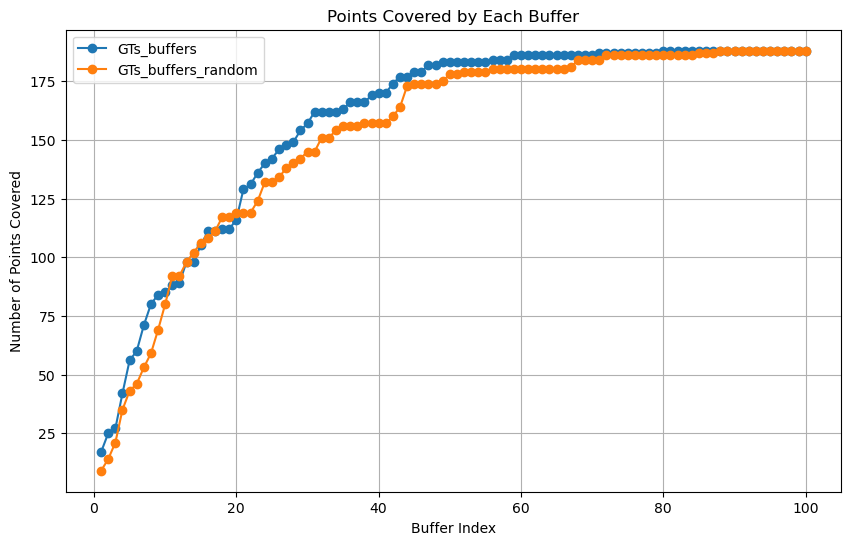

In [104]:
counts_buffers = []
counts_random = []

# Iterate over each buffer GeoDataFrame in GTs_buffers
for gdf in GTs_buffers:
    # Create a union of all polygons in the buffer gdf (if there is more than one)
    buffer_union = gdf.unary_union
    # Count the points in combined_points that fall within this union
    count = all_neighbourhoods_centroids.within(buffer_union).sum()
    counts_buffers.append(count)

# Do the same for GTs_buffers_random
for gdf in GTs_buffers_random:
    buffer_union = gdf.unary_union
    count = all_neighbourhoods_centroids.within(buffer_union).sum()
    counts_random.append(count)

# Plotting the results on a line graph
plt.figure(figsize=(10, 6))
x_vals = range(1, len(counts_buffers) + 1)  # Assuming you want x-axis as buffer index

plt.plot(x_vals, counts_buffers, marker='o', label='GTs_buffers')
plt.plot(x_vals, counts_random, marker='o', label='GTs_buffers_random')

plt.xlabel('Buffer Index')
plt.ylabel('Number of Points Covered')
plt.title('Points Covered by Each Buffer')
plt.legend()
plt.grid(True)
plt.show()

### Overlap

Overlap with existing infrastructure. Finding how much of the existing network we overlap, in terms of edges, distance, and % of total network

In [ ]:
# def compare_against_reference(graph_list1, graph_list2, reference_graph):
#     """
#     Compare two lists of graphs against a reference, calculating both:
#     1. How much of the reference is covered by each graph (original metric)
#     2. How much of each graph is covered by the reference (reverse metric)
#     """
#     def calculate_both_ways(graph, reference):
#         # Original: how much of reference is covered by graph
#         orig_size_pct, orig_len_pct, orig_edges, orig_len = calculate_overlap_percentages(reference, graph)
#         # Reverse: how much of graph is covered by reference
#         rev_size_pct, rev_len_pct, rev_edges, rev_len = calculate_overlap_percentages(graph, reference)
#         return (orig_size_pct, orig_len_pct, orig_edges, orig_len,
#                 rev_size_pct, rev_len_pct, rev_edges, rev_len)
    
#     metrics_list1 = [calculate_both_ways(g, reference_graph) for g in graph_list1]
#     metrics_list2 = [calculate_both_ways(g, reference_graph) for g in graph_list2]
    
#     return metrics_list1, metrics_list2

# def plot_comparison(metrics_GTs, metrics_GTs_random):
#     """Plot comparison with separate views for both metrics"""
#     fig, axes = plt.subplots(4, 1, figsize=(12, 16))
    
#     # Original percentage metrics (how much of REFERENCE is covered)
#     axes[0].plot([m[0] for m in metrics_GTs], 'b-', label='GTs Size (Ref Covered)')
#     axes[0].plot([m[0] for m in metrics_GTs_random], 'r--', label='GTs_random Size (Ref Covered)')
#     axes[0].plot([m[1] for m in metrics_GTs], 'g-', label='GTs Length (Ref Covered)')
#     axes[0].plot([m[1] for m in metrics_GTs_random], 'm--', label='GTs_random Length (Ref Covered)')
#     axes[0].set_title('Percentage of Reference Covered')
#     axes[0].set_ylabel('Percentage')
#     axes[0].legend()
#     axes[0].grid(True)
    
#     # Reverse percentage metrics (how much of NETWORK is covered by reference)
#     axes[1].plot([m[4] for m in metrics_GTs], 'b-', label='GTs Size (Network Covered)')
#     axes[1].plot([m[4] for m in metrics_GTs_random], 'r--', label='GTs_random Size (Network Covered)')
#     axes[1].plot([m[5] for m in metrics_GTs], 'g-', label='GTs Length (Network Covered)')
#     axes[1].plot([m[5] for m in metrics_GTs_random], 'm--', label='GTs_random Length (Network Covered)')
#     axes[1].set_title('Percentage of Network Covered by Reference')
#     axes[1].set_ylabel('Percentage')
#     axes[1].legend()
#     axes[1].grid(True)
    
#     # Raw edge counts
#     axes[2].plot([m[2] for m in metrics_GTs], 'b-', label='GTs Edges (Ref Covered)')
#     axes[2].plot([m[2] for m in metrics_GTs_random], 'r--', label='GTs_random Edges (Ref Covered)')
#     axes[2].plot([m[6] for m in metrics_GTs], 'g-', label='GTs Edges (Network Covered)')
#     axes[2].plot([m[6] for m in metrics_GTs_random], 'm--', label='GTs_random Edges (Network Covered)')
#     axes[2].set_title('Raw Edge Counts')
#     axes[2].set_ylabel('Edges')
#     axes[2].legend()
#     axes[2].grid(True)
    
#     # Raw lengths
#     axes[3].plot([m[3] for m in metrics_GTs], 'b-', label='GTs Length (Ref Covered)')
#     axes[3].plot([m[3] for m in metrics_GTs_random], 'r--', label='GTs_random Length (Ref Covered)')
#     axes[3].plot([m[7] for m in metrics_GTs], 'g-', label='GTs Length (Network Covered)')
#     axes[3].plot([m[7] for m in metrics_GTs_random], 'm--', label='GTs_random Length (Network Covered)')
#     axes[3].set_title('Raw Length Overlap')
#     axes[3].set_ylabel('Length')
#     axes[3].legend()
#     axes[3].grid(True)
    
#     plt.tight_layout()
#     plt.show()

# reference = G_biketrack  # Your reference infrastructure
# metrics_GTs, metrics_GTs_random = compare_against_reference(GTs, GTs_random, reference)
# plot_comparison(metrics_GTs, metrics_GTs_random)

In [ ]:
def calculate_overlap_percentages(G_biketrack, G):
    # Calculate edge overlap and length overlap
    overlapping_edges = 0
    overlapping_length = 0
    total_edges = G_biketrack.number_of_edges()
    total_length = sum(data['length'] for u, v, data in G_biketrack.edges(data=True))
    
    for u, v, data in G_biketrack.edges(data=True):
        if G.has_edge(u, v):
            overlapping_edges += 1
            overlapping_length += data['length']
    
    if total_edges == 0:
        size_percent = 0.0
    else:
        size_percent = (overlapping_edges / total_edges) * 100
    
    if total_length == 0:
        length_percent = 0.0
    else:
        length_percent = (overlapping_length / total_length) * 100
    
    return size_percent, length_percent, overlapping_edges, overlapping_length


def compare_against_existing(graph_list1, graph_list2, reference_graph):
    """
    Compare two lists of graphs against a common reference graph.
    Returns metrics for both lists compared to the reference.
    """
    # Calculate metrics for both lists against the reference
    metrics_list1 = [calculate_overlap_percentages(g, reference_graph) for g in graph_list1]
    metrics_list2 = [calculate_overlap_percentages(g, reference_graph) for g in graph_list2]
    
    return metrics_list1, metrics_list2

def plot_comparison(metrics_GTs, metrics_GTs_random):
    """Plot comparison between GTs and GTs_random against G_biketrack"""
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
    
    # Percentage plot
    ax1.plot([m[0] for m in metrics_GTs], 'b-', label='GTs Size Overlap (%)')
    ax1.plot([m[0] for m in metrics_GTs_random], 'r--', label='GTs_random Size Overlap (%)')
    ax1.plot([m[1] for m in metrics_GTs], 'g-', label='GTs Length Overlap (%)')
    ax1.plot([m[1] for m in metrics_GTs_random], 'm--', label='GTs_random Length Overlap (%)')
    ax1.set_title('Percentage Overlap with Existing Cycle Infrastructure (Including LTNs)')
    ax1.set_ylabel('Percentage')
    ax1.legend()
    ax1.grid(True)
    
    # Edge count plot
    ax2.plot([m[2] for m in metrics_GTs], 'b-', label='GTs Overlapping Edges')
    ax2.plot([m[2] for m in metrics_GTs_random], 'r--', label='GTs_random Overlapping Edges')
    ax2.set_title('Edge Overlap Comparison')
    ax2.set_ylabel('Edge Count')
    ax2.legend()
    ax2.grid(True)
    
    # Length plot
    ax3.plot([m[3] for m in metrics_GTs], 'g-', label='GTs Overlapping Length')
    ax3.plot([m[3] for m in metrics_GTs_random], 'm--', label='GTs_random Overlapping Length')
    ax3.set_title('Length Overlap Comparison')
    ax3.set_ylabel('Length Units')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()



metrics_GTs, metrics_GTs_random = compare_against_existing(GTs, GTs_random, G_biketrack)
plot_comparison(metrics_GTs, metrics_GTs_random)

In [ ]:
metrics_GTs, metrics_GTs_random = compare_against_existing(GTs, GTs_random, G_biketrack_no_ltn) # no differance?
plot_comparison(metrics_GTs, metrics_GTs_random)

In [ ]:
# #### to explore it

# # work in meters
# G_biketrack_edges = G_biketrack_edges.to_crs(epsg=3857)
# G_edges = G_edges.to_crs(epsg=3857)
# G_biketrack_edges['geometry'] = G_biketrack_edges.geometry.buffer(1)
# G_edges['geometry'] = G_edges.geometry.buffer(1)
# joined = gpd.sjoin(G_biketrack_edges, G_edges, how="inner", predicate="intersects", lsuffix="_biketrack", rsuffix="_edge")

# joined.explore()

### Directness

Directness (Directness=Total Sum of Network Distances/Total Sum of Euclidean Distances​)

In [ ]:
net_dist = []
eucl_dist = []
directness = []

for G in GT_abstracts:
    total_net_dist = sum(data.get('eucl_dist', 0) for _, _, data in G.edges(data=True))
    total_eucl_dist = sum(data.get('sp_true_distance', 0) for _, _, data in G.edges(data=True))
    net_dist.append(total_net_dist)
    eucl_dist.append(total_eucl_dist)
    if total_net_dist != 0:
        ratio = total_eucl_dist / total_net_dist
    else:
        ratio = None
    directness.append(ratio)


net_dist_random = []
eucl_dist_random = []
directness_random = []

for G in GT_abstracts_random:
    total_net_dist = sum(data.get('eucl_dist', 0) for _, _, data in G.edges(data=True))
    total_eucl_dist = sum(data.get('sp_true_distance', 0) for _, _, data in G.edges(data=True))
    net_dist_random.append(total_net_dist)
    eucl_dist_random.append(total_eucl_dist)
    if total_net_dist != 0:
        ratio = total_eucl_dist / total_net_dist
    else:
        ratio = None
    directness_random.append(ratio)



# Plotting 
plt.figure(figsize=(10, 6))
plt.plot(directness, linestyle='-', color='blue', label='Betweeness')
plt.plot(directness_random, linestyle='--', color='orange', label='Random')
plt.xlabel('Graph Index')
plt.ylabel('Directness (Euclidean / Network Distance)')
plt.title('Total Network Directness')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# calcaulate directness of existing network to compare against...

## Efficiency

### Global

In [ ]:
# ## edit plotting
# def calculate_efficiency(G):
#     """Calculate global network efficiency using formula E = 1/(N(N-1)) * Σ 1/d_ij"""
#     # Convert to undirected graph
#     undirected_G = nx.Graph(G)
#     try:
#         return nx.global_efficiency(undirected_G)
#     except nx.NetworkXError:
#         return 0  # Handle disconnected graphs

# def plot_efficiency_comparison(GTs, GTs_random):
#     """Calculate and plot global efficiency for both graph lists"""
#     # Calculate efficiencies
#     eff_GTs = [calculate_efficiency(G) for G in GTs]
#     eff_random = [calculate_efficiency(G) for G in GTs_random]
    
#     # Create plot
#     plt.figure(figsize=(10, 6))
#     plt.plot(eff_GTs, 'b-', linewidth=2, label='GTs Efficiency')
#     plt.plot(eff_random, 'r--', linewidth=2, label='GTs_random Efficiency')
    
#     plt.title('Global Network Efficiency Comparison\n$E = \\frac{1}{N(N-1)}\\sum_{i\\neq j} \\frac{1}{d_{ij}}$')
#     plt.ylabel('Global Efficiency')
#     plt.xlabel('Graph Instance Index')
#     plt.legend()
#     plt.grid(True)
#     plt.ylim(0, 1)
#     plt.tight_layout()
#     plt.show()

# # Usage example:
# plot_efficiency_comparison(GTs, GTs_random)

In [ ]:
def calculate_global_efficiency(G, numnodepairs=500, normalized=True, weight='weight', debug=False):
    """Calculates global network efficiency for a graph G.
    
    Parameters:
    - G: NetworkX graph
    - numnodepairs: Maximum number of node pairs to consider (for large graphs)
    - normalized: If True, normalize by the ideal efficiency based on Euclidean distances (requires 'x' and 'y' node attributes)
    - weight: Edge attribute to use for shortest path calculation
    - debug: Print debug information
    
    Returns:
    - Global efficiency (normalized or unnormalized)
    """
    if G is None or len(G) < 2:
        return 0.0
    
    nodes = list(G.nodes)
    N = len(nodes)
    
    # Sample nodes if the graph is large
    if N > numnodepairs:
        sampled_nodes = random.sample(nodes, numnodepairs)
    else:
        sampled_nodes = nodes
    S = len(sampled_nodes)
    if S < 2:
        return 0.0
    
    # Calculate the sum of reciprocals of shortest path lengths
    total_efficiency = 0.0
    for u in sampled_nodes:
        try:
            # Get shortest paths from u to all other sampled nodes
            lengths = nx.single_source_dijkstra_path_length(G, u, weight=weight)
            for v in sampled_nodes:
                if u == v:
                    continue
                d = lengths.get(v, float('inf'))
                if d > 0 and d != float('inf'):
                    total_efficiency += 1 / d
        except nx.NetworkXNoPath:
            # Handle cases where no path exists from u
            continue
    
    # Calculate the number of considered pairs (excluding self-pairs)
    considered_pairs = S * (S - 1)
    if considered_pairs == 0:
        return 0.0
    
    # Unnormalized efficiency (sum of reciprocals)
    EG = total_efficiency
    
    if not normalized:
        # Apply the formula E = (total_efficiency) / (N*(N-1))
        # This scales the sample sum to estimate the total
        efficiency = EG / (N * (N - 1))
        return efficiency
    
    # Normalize by the ideal efficiency (Euclidean distances)
    # Check for 'x' and 'y' attributes
    for node in sampled_nodes:
        if 'x' not in G.nodes[node] or 'y' not in G.nodes[node]:
            raise KeyError("Nodes must have 'x' and 'y' attributes for normalization.")
    
    # Calculate ideal efficiency based on Euclidean distance
    ideal_total = 0.0
    pairs = itertools.permutations(sampled_nodes, 2)
    for u, v in pairs:
        x1, y1 = G.nodes[u]['x'], G.nodes[u]['y']
        x2, y2 = G.nodes[v]['x'], G.nodes[v]['y']
        dx = x1 - x2
        dy = y1 - y2
        distance = (dx**2 + dy**2) ** 0.5
        if distance > 0:
            ideal_total += 1 / distance
    
    if ideal_total == 0:
        return 0.0
    
    # Normalized efficiency
    efficiency = EG / ideal_total
    
    if debug:
        print(f"EG: {EG}, Ideal EG: {ideal_total}, Normalized Efficiency: {efficiency}")
    
    return efficiency

In [ ]:
calculate_global_efficiency(G, numnodepairs=500, normalized=True, weight='length', debug=False)

In [ ]:
# Calculate efficiencies for both graph sets
eff_GTs = [calculate_global_efficiency(G, numnodepairs=500, normalized=True) for G in GTs]
eff_GTs_random = [calculate_global_efficiency(G, numnodepairs=500, normalized=True) for G in GTs_random]

# Create x-axis values (time steps/graph indices)
x = list(range(len(eff_GTs)))
x_random = list(range(len(eff_GTs_random)))

# Create plot
plt.figure(figsize=(10, 6))

# Plot both lines
plt.plot(x, eff_GTs, label='GTs',  linestyle='-', color='blue')
plt.plot(x_random, eff_GTs_random, label='GTs Random', linestyle='--', color='red')

# Add labels and title
plt.xlabel('Graph Index', fontsize=12)
plt.ylabel('Global Efficiency', fontsize=12)
plt.title('Global Network Efficiency Comparison', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Customize ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
# Create plot
plt.figure(figsize=(10, 6))

# Plot both lines
plt.plot(x, eff_GTs, label='GTs',  linestyle='-', color='blue')
plt.plot(x_random, eff_GTs_random, label='GTs Random', linestyle='--', color='red')

# Add labels and title
plt.xlabel('Graph Index', fontsize=12)
plt.ylabel('Global Efficiency', fontsize=12)
plt.title('Global Network Efficiency Comparison', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Customize ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show plot
plt.tight_layout()
plt.show()

### Local

Both

In [ ]:
# def calculate_efficiencies(G):
#     """Calculate both global and local efficiencies"""
#     # Convert to undirected graph
#     undirected_G = nx.Graph(G)
    
#     try:
#         global_eff = nx.global_efficiency(undirected_G)
#     except nx.NetworkXError:
#         global_eff = 0
        
#     try:
#         local_eff = nx.local_efficiency(undirected_G)
#     except nx.NetworkXError:
#         local_eff = 0
        
#     return global_eff, local_eff

# def plot_efficiency_comparison(GTs, GTs_random):
#     """Plot comparison of both efficiency metrics"""
#     # Calculate efficiencies
#     global_GTs, local_GTs = zip(*[calculate_efficiencies(G) for G in GTs])
#     global_random, local_random = zip(*[calculate_efficiencies(G) for G in GTs_random])
    
#     # Create plots
#     fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
#     # Global efficiency plot
#     ax1.plot(global_GTs, 'b-', linewidth=2, label='GTs Global Eff')
#     ax1.plot(global_random, 'r--', linewidth=2, label='GTs_random Global Eff')
#     ax1.set_title('Global Network Efficiency Comparison')
#     ax1.set_ylabel('Efficiency')
#     ax1.legend()
#     ax1.grid(True)
#     ax1.set_ylim(0, 1)
    
#     # Local efficiency plot
#     ax2.plot(local_GTs, 'g-', linewidth=2, label='GTs Local Eff')
#     ax2.plot(local_random, 'm--', linewidth=2, label='GTs_random Local Eff')
#     ax2.set_title('Local Network Efficiency Comparison')
#     ax2.set_ylabel('Efficiency')
#     ax2.legend()
#     ax2.grid(True)
#     ax2.set_ylim(0, 1)
    
#     plt.tight_layout()
#     plt.show()

# # Usage example:
# plot_efficiency_comparison(GTs, GTs_random)

## PCT

In [ ]:
# read in pct lines

## Pretty plots of networks

In [ ]:
iteration_number = 99

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the width and height as needed



G_biketrackcarall_edges = ox.graph_to_gdfs(G_biketrackcarall, nodes=False)
G_biketrackcarall_edges = G_biketrackcarall_edges.to_crs(epsg=3857)  # Ensure CRS matches
G_biketrackcarall_edges.plot(ax=ax, color='lightgrey', linewidth=0.5, alpha=0.8, zorder = 0)  # Light grey with thin linewidth

# Add bike track edges
#G_biketrack = {}
#G_biketrack[placeid] = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'biketrack')
#G_biketrack[placeid].graph["crs"] = 'epsg:4326'  # Needed for OSMNX's graph_to_gdfs in utils_graph.py
#G_biketrack = copy.deepcopy(G_biketrack[placeid])
G_biketrack_edges = ox.graph_to_gdfs(G_biketrack, nodes=False)
G_biketrack_edges = G_biketrack_edges.to_crs(epsg=3857)
G_biketrack_edges.plot(ax=ax, color='turquoise', linewidth=0.5, alpha=0.8, zorder = 1)  # Light grey with thin linewidth


# Plot the main graph and layers
GT_nodes, GT_edges = ox.graph_to_gdfs(GTs[iteration_number])
GT_edges = GT_edges.to_crs(epsg=3857)
GT_edges.plot(ax=ax, color='orange')
ltn_points.to_crs(epsg=3857).plot(ax=ax, color='red', markersize=10, zorder=4)
tess_points.to_crs(epsg=3857).plot(ax=ax, color='green', markersize=5, zorder = 3)


ltns = ltns.to_crs(epsg=3857)  # Ensure the CRS matches
ltns.plot(ax=ax, color='blue', alpha=0.5, label=f"Low Traffic Neighbourhoods", zorder=2)


# Remove x and y axis labels and ticks
ax.axis('off')  # This removes the entire axis, including labels and ticks

# Enhance plot aesthetics
ax.set_title(f"Investment %: {iteration_number}")
ax.legend(loc="upper left")

# Show the plot
plt.show()


In [ ]:
Audio(sound_file, autoplay=True) 